In [14]:
#from veneer.manage import create_command_line

#import veneer-py

from veneer.manage import start, create_command_line, kill_all_now
import veneer
import geopandas
import pandas as pd

In [2]:
veneer_install = 'D:/PythonScriptingForGBR/VeneerPlugin/v411'
source_version = '4.1.1'
cmd_directory = 'C:\\tempveneer\\veneer_cmd'
path = create_command_line(veneer_install,source_version,dest=cmd_directory)
path

'C:\\tempveneer\\veneer_cmd\\FlowMatters.Source.VeneerCmd.exe'

In [3]:
catchment_project='D:\\Xike\\bu\\bu_reefhydro_bo_411_noMP.rsproj'
num_copies=1    # Important - set this to be a number ~ the number of CPU cores in your system!
first_port=9950

In [4]:
processes,ports = start(catchment_project,
                        n_instances=num_copies,
                        ports=first_port,
                        debug=True,
                        veneer_exe=path,
                        remote=False)

Starting C:\tempveneer\veneer_cmd\FlowMatters.Source.VeneerCmd.exe -p 9950 -s  "D:\Xike\bu\bu_reefhydro_bo_411_noMP.rsproj"
[0] Loading plugins

[0] Loaded C:\Program Files\eWater\Source 4.1.1.4513\Plugins\DERMTools.dll

[0] Loaded C:\Program Files\eWater\Source 4.1.1.4513\Plugins\PestFileProductionTools.dll

[0] Loaded C:\Program Files\eWater\Source 4.1.1.4513\Plugins\RebuildInternalSubcatchmentRaster.dll

[0] Loaded C:\Program Files\eWater\Source 4.1.1.4513\Plugins\ReefHydroCalModels.dll

[0] Loaded C:\Program Files\eWater\Source 4.1.1.4513\Plugins\SneakyLinkModelEditor.dll

[0] Loaded C:\Program Files\eWater\Source 4.1.1.4513\Plugins\Dynamic_SedNet.dll

[0] Loaded C:\Program Files\eWater\Source 4.1.1.4513\Plugins\GBR_DynSed_Extension.dll

[0] Plugins loaded (7/7)

[0] Opening project file: D:\Xike\bu\bu_reefhydro_bo_411_noMP.rsproj

ERROR[0] log4net:ERROR Failed to find configuration section 'log4net' in the application's .config file. Check your .config file for the <log4net> and <

In [5]:
vs = [veneer.Veneer(port=p) for p in ports]

In [6]:
#kill_all_now(processes)

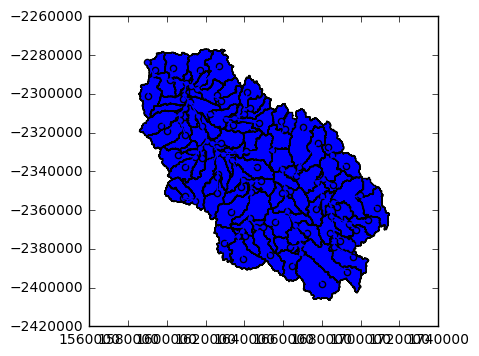

In [8]:
%matplotlib inline
v = vs[0]
v.network().as_dataframe().plot()

In [9]:
sDate = v.model.get('scenario.CurrentConfiguration.StartDate')
print(sDate)

eDate = v.model.get('scenario.CurrentConfiguration.EndDate')
print(eDate)

#v.run_model()

1/01/2000 12:00:00 AM
31/03/2000 11:00:00 PM


In [10]:
the_network = v.network()
outlets = the_network.outlet_nodes()
outlets

[{'properties': {'feature_type': 'node', 'icon': '/resources/ConfluenceNodeModel', 'name': 'Node on catchment SC #113', 'schematic_location': [0, 0]}, 'type': 'Feature', 'geometry': {'coordinates': [1589773.63051, -2283475.4690071], 'type': 'Point'}, 'id': '/network/nodes/258'}]

In [11]:
def processLinks(the_network, gaugeList, linkregs, currentLink, currentReg):
    
    theLinkName = currentLink['properties']['name']
    
    ## check if this link is a reporting point
    if theLinkName in gaugeList:
        currentReg = theLinkName
        print("Found this (link) network element: " + theLinkName)
    
    ## update the dictionary
    linkregs[theLinkName] = currentReg
    
    #print("Link info: " + str(currentLink))
    
    fNodeID = currentLink['properties']['from_node']
    
    #print("Node info: " + fNodeID)
    
    fNode = the_network['features'].find_by_id(fNodeID)
    #print(fNode)
    
    fNodeName = fNode[0]['properties']['name']
    #print(fNodeName)
    
    ## check if this link is a reporting point
    if fNodeName in gaugeList:
        currentReg = fNodeName
        print("Found this (node) network element: " + fNodeName)
    
    ## recurse
    #print(the_network.upstream_links(fNode[0]))
    for upLink in the_network.upstream_links(fNode[0]):
        #print("Now processing: " + upLink['properties']['name'])
        processLinks(the_network, gaugeList, linkregs, upLink, currentReg)

    return

In [34]:
noRegStr = 'NoReg'
#gaugeList = ['120219A','120206A','link for catchment SC #139']
gaugeList = ['120205A','120206A','120207A','120209A','120212A','120213A','120214A','120219A']

# will assign regions to links, pair with subcatchs late
all_links = the_network['features'].find_by_feature_type('link')
linkregs = {}

## Populate the dictionary of relationships first
for link in all_links:
    linkregs[link['properties']['name']] = noRegStr

## now process the network
for outNode in outlets:
    curReg = noRegStr
    
    #print(outNode.keys())
    #print(outNode['properties'].keys())
    #print(outNode['properties']['name'])
    
    thisNodeName = outNode['properties']['name']
    
    if thisNodeName in gaugeList:
        print("Found this network element: " + thisNodeName)
        ##Set the curReg
        curReg = thisNodeName
    #else:
    #    print (thisNodeName + " was not in the list")
    
    
    ## now we begin processing
    for upLink in the_network.upstream_links(outNode):
        processLinks(the_network, gaugeList, linkregs, upLink, curReg)
    

Found this (node) network element: 120219A
Found this (node) network element: 120206A
Found this (node) network element: 120205A
Found this (node) network element: 120209A
Found this (node) network element: 120214A
Found this (node) network element: 120212A
Found this (link) network element: 120213A
Found this (node) network element: 120207A


In [35]:
linkregs_df = pd.DataFrame(list(linkregs.items()), columns=['LinkName','RegName'])
linkregs_df
#help(v.network)
#help(run_results2)

,LinkName,RegName
0,link for catchment SC #226,120219A
1,link for catchment SC #210,120205A
2,link for catchment SC #154,120212A
3,link for catchment SC #145,120209A
4,link for catchment SC #206,120205A
5,link for catchment SC #149,120209A
6,link for catchment SC #147,120209A
7,link for catchment SC #131,120206A
8,link for catchment SC #127,120219A
9,link for catchment SC #1675,120207A


In [36]:
network_df = v.network().as_dataframe()
catchdf = network_df[network_df.feature_type=='catchment']
linkdf = network_df[network_df.feature_type=='link']

catchlinkdf = pd.merge(catchdf, linkdf, how='inner', left_on=['link'], right_on=['id'])
catchlinkdf = catchlinkdf.rename(columns={'areaInSquareMeters_y':'linkarea', 'areaInSquareMeters_x':'areaInSquareMeters', 'feature_type_y':'link_feat_type', 'feature_type_x':'feature_type', 'geometry_y':'link_geom', 'geometry_x':'geometry', 'name_y': 'link_name'})

catchlinkdfregdf = pd.merge(catchlinkdf, linkregs_df, how='inner', left_on=['link_name'], right_on=['LinkName'])

catchlinkdfregdf.head(8)

,areaInSquareMeters,feature_type,from_node_x,geometry,icon_x,link_x,name_x,schematic_location_x,to_node_x,id_x,...,from_node_y,link_geom,icon_y,link_y,link_name,schematic_location_y,to_node_y,id_y,LinkName,RegName
0,115784100.0,catchment,NaN,"(POLYGON ((1598608.63051 -2326900.4690071, 159...",NaN,/network/link/105,SC #219,NaN,NaN,/network/catchments/5397,...,/network/nodes/477,"LINESTRING (1605553.63051 -2331745.4690071, 16...",NaN,NaN,link for catchment SC #219,NaN,/network/nodes/473,/network/link/105,link for catchment SC #219,120205A
1,107757900.0,catchment,NaN,"(POLYGON ((1614268.63051 -2332540.4690071, 161...",NaN,/network/link/104,SC #218,NaN,NaN,/network/catchments/5748,...,/network/nodes/476,"LINESTRING (1609543.63051 -2337715.4690071, 16...",NaN,NaN,link for catchment SC #218,NaN,/network/nodes/473,/network/link/104,link for catchment SC #218,120205A
2,51212700.0,catchment,NaN,"(POLYGON ((1651138.63051 -2301430.4690071, 165...",NaN,/network/link/20,SC #134,NaN,NaN,/network/catchments/6927,...,/network/nodes/309,"LINESTRING (1639783.63051 -2310325.4690071, 16...",NaN,NaN,link for catchment SC #134,NaN,/network/nodes/301,/network/link/20,link for catchment SC #134,120206A
3,102207600.0,catchment,NaN,"(POLYGON ((1634758.63051 -2305240.4690071, 163...",NaN,/network/link/115,SC #1672,NaN,NaN,/network/catchments/7314,...,/network/nodes/295,"LINESTRING (1630783.63051 -2312785.4690071, 16...",NaN,NaN,link for catchment SC #1672,NaN,/network/nodes/293,/network/link/115,link for catchment SC #1672,120206A
4,117614700.0,catchment,NaN,"(POLYGON ((1653688.63051 -2307370.4690071, 165...",NaN,/network/link/21,SC #135,NaN,NaN,/network/catchments/7341,...,/network/nodes/310,"LINESTRING (1647493.63051 -2315125.4690071, 16...",NaN,NaN,link for catchment SC #135,NaN,/network/nodes/298,/network/link/21,link for catchment SC #135,120206A
5,55891800.0,catchment,NaN,"(POLYGON ((1649878.63051 -2366380.4690071, 164...",NaN,/network/link/85,SC #199,NaN,NaN,/network/catchments/7359,...,/network/nodes/443,"LINESTRING (1649803.63051 -2368915.4690071, 16...",NaN,NaN,link for catchment SC #199,NaN,/network/nodes/440,/network/link/85,link for catchment SC #199,120205A
6,143916300.0,catchment,NaN,"(POLYGON ((1687888.63051 -2378290.4690071, 168...",NaN,/network/link/116,SC #1675,NaN,NaN,/network/catchments/7629,...,/network/nodes/3383,"LINESTRING (1696243.63051 -2383915.4690071, 16...",NaN,NaN,link for catchment SC #1675,NaN,/network/nodes/391,/network/link/116,link for catchment SC #1675,120207A
7,57864600.0,catchment,NaN,"(POLYGON ((1624858.63051 -2341240.4690071, 162...",NaN,/network/link/97,SC #211,NaN,NaN,/network/catchments/7809,...,/network/nodes/463,"LINESTRING (1626103.63051 -2342635.4690071, 16...",NaN,NaN,link for catchment SC #211,NaN,/network/nodes/459,/network/link/97,link for catchment SC #211,120205A


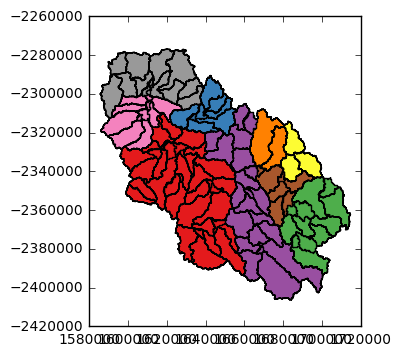

In [37]:
catchlinkdfregdf.plot(column='RegName')

In [38]:
kill_all_now(processes)